In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

## Import Data

In [4]:
PATH = '/home/danieldiamond/data/dogbreed/'

In [5]:
os.listdir(PATH)

['labels.csv', 'tmp', 'train', 'sample_submission.csv', 'test']

In [6]:
labels=pd.read_csv(PATH+'labels.csv')

In [7]:
labels_train = labels.sample(frac=0.8)
labels_valid = labels[~labels.index.isin(labels_train.index)]

In [8]:
labels_train.shape,labels_valid.shape

((8178, 2), (2044, 2))

In [9]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [10]:
labels.pivot_table(index='breed',aggfunc=len).sort_values('id',ascending=False).head()

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


In [11]:
files = os.listdir(f'{PATH}test')[:5]
files

['41bb88e8da45c400490febc6d8d13689.jpg',
 'e06fdea86b416e992137ad52bb5da5a8.jpg',
 '4b6ba16df7da3185a747cacbf37d7072.jpg',
 '555aab3f3ce67bf7ffd6313717abcd77.jpg',
 '5bba97f88dbe095b004c5e25bd9e5a90.jpg']

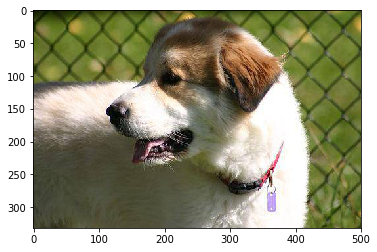

In [12]:
img = plt.imread(f'{PATH}test/{files[0]}')
plt.imshow(img);

In [13]:
img.shape

(332, 500, 3)

### Image Size and Batch Size

In [19]:
# set the size for the transformer to resize all images
sz = 224

# set the batch size (smaller allows computing to occur faster)
bs=58

### Architecture

Deep Convolutional Neural Networks have been groundbreaking in terms of image classification. Thus, there has been a trending to increase /improve the classification/recognition accuracy. However, the deeper you go, the more difficult training of neural network becomes and similarly the accuracy starts to saturate and degrade. This is where Residual Learning comes in.

In [20]:
# set the architecture (pre-trained model)
arch=resnext50
# arch=resnext101_64

### What is Residual Learning?

In general, in a deep convolutional neural network, several layers are stacked and are trained to the task at hand. The network learns several low/mid/high level features at the end of its layers. In residual learning, instead of trying to learn some features, we try to learn some residual. Residual can be simply understood as subtraction of feature learned from input of that layer. ResNet does this using shortcut connections (directly connecting input of nth layer to some (n+x)th layer. It has proved that training this form of networks is easier than training simple deep convolutional neural networks and also the problem of degrading accuracy is resolved.

This is the fundamental concept of ResNet.<br>
https://arxiv.org/pdf/1512.03385.pdf

ResNet50 is a 50 layer Residual Network.<br>
http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006

There are other variants like ResNet101 and ResNet152 also.

<i>Deep neural networks are susceptible to vanishing gradients. Resnet used skip connection to propagate information over layers allowing Data scientist to build deeper networks. Skip connection helps the network to understand global features. In CNN due to maxpooling information can get lost. It enhances the detection of smaller objects in the image.</i>

### Transformer

In [21]:
tfms=tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)

In [65]:
data = ImageClassifierData.from_csv(PATH,'train',PATH+'labels.csv',test_name='test',
                                     val_idxs=labels_valid.index,
                                     suffix='.jpg',tfms=tfms,bs=bs)

In [23]:
fn = PATH+data.trn_ds.fnames[0]; fn

'/home/danieldiamond/data/dogbreed/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

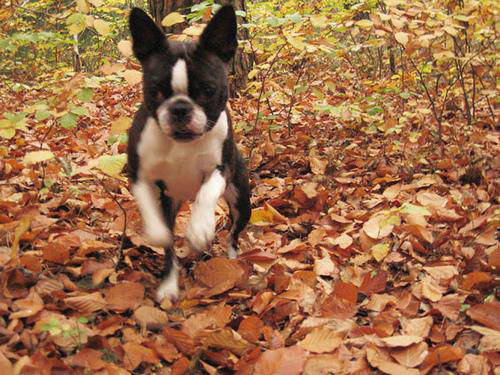

In [24]:
img = PIL.Image.open(fn); img

In [29]:
print ('data :',list(data.__dict__.keys()))
print ('training dataset :',list(data.trn_ds.__dict__.keys()))

data : ['path', 'bs', 'num_workers', 'classes', 'trn_dl', 'val_dl', 'fix_dl', 'aug_dl', 'test_dl', 'test_aug_dl']
training dataset : ['y', 'path', 'fnames', 'transform', 'n', 'c', 'sz']


### Reviewing Image Sizes

In [30]:
size_df=pd.DataFrame([(i,)+PIL.Image.open(PATH+i).size for i in data.trn_ds.fnames],
             columns=['fn','width','height'])

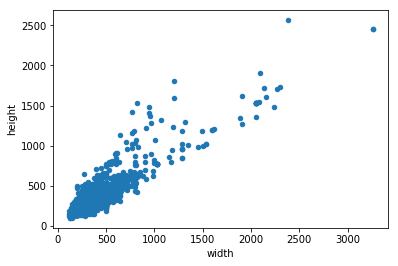

In [31]:
size_df.plot(kind='scatter',x='width',y='height');

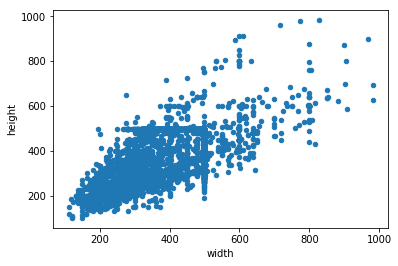

In [32]:
size_df[(size_df.width<1000)&
       (size_df.height<1000)].plot(kind='scatter',x='width',y='height');

In [33]:
len(data.trn_ds),len(data.test_ds)

(8178, 10357)

In [34]:
len(data.classes)

120

In [35]:
def get_data(sz,bs):
    tfms=tfms_from_model(arch,sz,aug_tfms=transforms_side_on,max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH,'train',PATH+'labels.csv',test_name='test',
                                         val_idxs=labels_valid.index,
                                         suffix='.jpg',tfms=tfms,bs=bs)
    return data if sz>300 else data.resize(340,'tmp')

In [36]:
data=get_data(sz,bs)

In [66]:
learn=ConvLearner.pretrained(arch,data,precompute=True)

100%|██████████| 179/179 [01:47<00:00,  2.00it/s]


In [51]:
learn.fit(1e-2,2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.476709   0.385536   0.885029  
    1      0.347527   0.358343   0.895793                    



[array([0.35834]), 0.895792570366085]

In [67]:
log_preds=learn.predict()

In [68]:
log_preds.shape

(2044, 120)

i.e. For each image in the validation set, there is a probability that the image pertains to that one (of 120) specific breeds.

In [70]:
# np.argmax returns the index associated with the highest probability. 
# i.e. the most likely breed for each image
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1

# learn.predict() returns log-scale probabilities, 
# therefore convert these into probabilitys from 0 to 1. 
# i.e. probability of breed associated with it's index.
probs = np.exp(log_preds[:,1])

In [93]:
def print_img_pred(i):
    print ('img:',labels_valid.iloc[i].id,'\n'
           'breed:',labels_valid.iloc[i].breed,'\n'
           'predicted breed:',data.classes[preds[i]],'\n'
           'probability:',probs[i])

In [94]:
print_img_pred(1)

img: 00290d3e1fdd27226ba27a8ce248ce85 
breed: bedlington_terrier 
predicted breed: miniature_pinscher 
probability: 0.006545738


In [96]:
valid_df=labels_valid.copy()

In [99]:
valid_df['pred_breed']=pd.Series([data.classes[preds[i]] for i in preds])
valid_df['probability']=pd.Series([i for i in probs])

In [100]:
valid_df.head()

,id,breed,pred_breed,probability
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,miniature_pinscher,0.006546
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier,miniature_pinscher,0.005759
7,002a283a315af96eaea0e28e7163b21b,borzoi,ibizan_hound,0.002638
18,007ff9a78eba2aebb558afea3a51c469,lakeland_terrier,redbone,0.004575
20,008b1271ed1addaccf93783b39deab45,doberman,ibizan_hound,0.006111


In [124]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified
Incorrectly classified


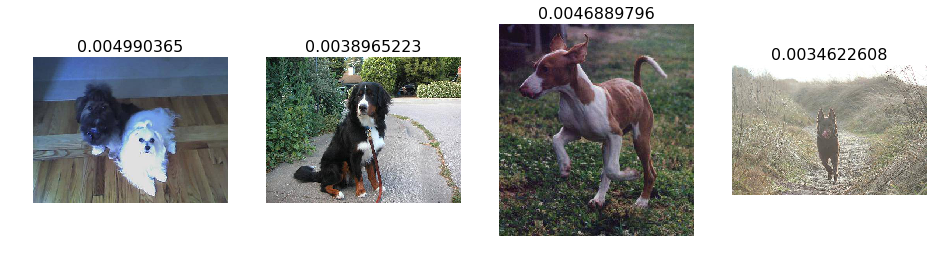

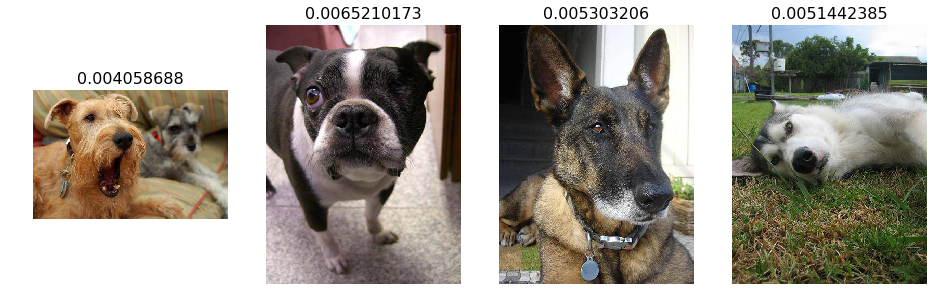

In [125]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [105]:
data.val_ds.y

array([37, 10, 18, ..., 41, 23,  3])

In [110]:
data.classes[37]

'dingo'

In [117]:
sum((data.val_ds.y==preds)*1)

13